In [1]:
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
import keras
from tensorflow  import keras
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.core import Dense,Activation,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [2]:
(train_imgs,train_labels),(test_imgs,test_labels) = keras.datasets.cifar100.load_data()
file =("cifar100labels.txt")
labels = np.loadtxt(file,dtype="U",delimiter=',')

In [3]:
print(f"train shape : {train_imgs.shape}  ---- test shape : {test_imgs.shape}")

train shape : (50000, 32, 32, 3)  ---- test shape : (10000, 32, 32, 3)


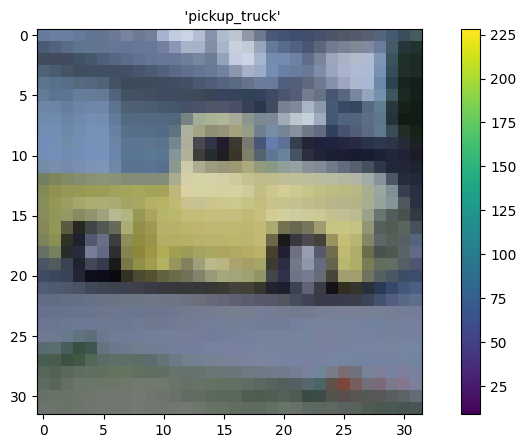

In [4]:
%matplotlib inline
plt.figure(figsize =(10,5))
x=random.randint(0,len(train_labels))
plt.imshow(train_imgs[x])
plt.title(labels[train_labels[x][0]],fontsize=10)
plt.colorbar()
plt.show()

In [4]:
from tensorflow.keras.utils import to_categorical

# Normalize images
train_imgs = train_imgs.astype('float32')/255
test_imgs = test_imgs.astype('float32')/255

# Transform labels to one hot encoding

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [5]:
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("val_accuracy")>0.6):
            print("\n accuracy reached the highest point,cancelling session")
            self.model.stop_training=True
callback = myCallback()
classes=100

In [6]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=train_imgs.shape[1:]))
model.add(Activation('elu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 activation_1 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 256)       295168    
                                                        

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its standard deviation
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1, 
            height_shift_range=0.1,  
            horizontal_flip=True,  
            vertical_flip=False)  

datagen.fit(train_imgs)

In [10]:
epoch=50
# Fit data to model
import time
training_start = time.time()
history = model.fit(datagen.flow(train_imgs, train_labels, batch_size=50), 
                   steps_per_epoch=train_imgs.shape[0] // 50,
                   epochs=epoch,
                   validation_data=(test_imgs, test_labels),
                   verbose=1,
                   callbacks=callback)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/50
1000/1000 [==============================] - 683s 683ms/step - loss: 3.4810 - accuracy: 0.1809 - val_loss: 2.9462 - val_accuracy: 0.2924
Epoch 2/50
1000/1000 [==============================] - 667s 667ms/step - loss: 3.1828 - accuracy: 0.2330 - val_loss: 2.7209 - val_accuracy: 0.3345
Epoch 3/50
1000/1000 [==============================] - 624s 624ms/step - loss: 3.0206 - accuracy: 0.2647 - val_loss: 2.5680 - val_accuracy: 0.3622
Epoch 4/50
1000/1000 [==============================] - 645s 645ms/step - loss: 2.9102 - accuracy: 0.2841 - val_loss: 2.4656 - val_accuracy: 0.3787
Epoch 5/50
1000/1000 [==============================] - 657s 657ms/step - loss: 2.8101 - accuracy: 0.3060 - val_loss: 2.3548 - val_accuracy: 0.4028
Epoch 6/50
1000/1000 [==============================] - 635s 635ms/step - loss: 2.7428 - accuracy: 0.3174 - val_loss: 2.3031 - val_accuracy: 0.4116
Epoch 7/50
1000/1000 [==============================] - 629s 629ms/step - loss: 2.6795 - accuracy: 0.3297 - val_

In [11]:
model.save("cifar100.model1",save_format='h5')

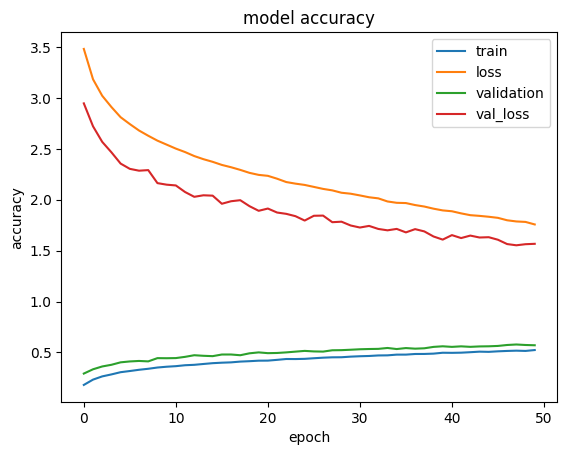

In [12]:
def plotting(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["val_loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", 'loss',"validation",'val_loss'], loc="best")
    plt.show()
plotting(history)

In [13]:
model.evaluate(test_imgs,test_labels)

313/313 [==============================] - 25s 78ms/step - loss: 1.5668 - accuracy: 0.5704


[1.5668078660964966, 0.5703999996185303]